# CS 5814 Homework 4, Part 2: Deep Q-Learning

In [10]:
!pip3 install gym pyvirtualdisplay # gym is the OpenAI gym: https://github.com/openai/gym
!pip3 install xvfbwrapper pyvirtualdisplay
!pip3 install pyopengl
!pip3 install ffmpeg-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
datadir = "/content/drive/My Drive/DQN/" # path to the homework
if not os.path.exists(datadir):
  !ln -s "" $datadir # path to the homework
os.chdir(datadir)
!pwd

/content/drive/My Drive/DQN


You should take a look at [this paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) before beginning. You'll be playing the game of __Breakout__.

In [ ]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from model import Model
from utils import count_max_lives, check_if_live, process_frame, get_initialization_state
from config import *

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [ ]:
!pip show gym

Name: gym
Version: 0.21.0
Summary: Gym: A universal API for reinforcement learning environments.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: jkterry@umd.edu
License: None
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, cloudpickle
Required-by: dopamine-rl


## Initialize env

Refer to the Gym [documentation](https://www.gymlibrary.dev/environments/atari/breakout/) for more details on the environment. There are three action_to_takes in this game - "left", "right" (to move the paddle) and "fire" (this releases the ball).

In [ ]:
env = gym.make('BreakoutDeterministic-v4')
# v0 vs v4: v0 has repeat_action_to_take_probability of 0.25 (meaning 25% of the time the previous action_to_take will be used instead of the new action_to_take), while v4 has 0 (always follow your issued action_to_take)
# Deterministic: a fixed frame_counterskip of 4, while for the env without Deterministic, frame_counterskip is sampled from (2,5)
# https://github.com/openai/gym/issues/1280
state = env.reset()

In [ ]:
max_number_of_lives_in_game = count_max_lives(env)
state_size = env.observation_space.shape
action_to_take_size = 3

## Create your agent

The agent is defined in the __your_agent.py__ file. We have coded a network for you already in the __model.py__ file. You shouldn't change the implementation we have there for fairness.

Once you get that working, you'll need to then create a double agent (see [this paper](https://arxiv.org/pdf/1509.06461.pdf)) in the __your_double_agent.py__ file. We have a switch below which determines which to train.

In [ ]:
double_d = True # switch

if double_d:
    from your_double_agent import EnvironmentAgent
else:
    from your_agent import EnvironmentAgent

agent = EnvironmentAgent(action_to_take_size) # buff size
rl_reward_from_eval = deque(maxlen=evaluation_reward_window) # This is avg rl_reward from 100 games
cnt_frame= 0
memory_size = 0

### Training

For episode: 0   the run_score was: 0.0   and mem length: 123   eps: 1.0    steps: 123    lr: 0.0001     eval rl_reward: 0.0
For episode: 1   the run_score was: 1.0   and mem length: 275   eps: 1.0    steps: 152    lr: 0.0001     eval rl_reward: 0.5
For episode: 2   the run_score was: 0.0   and mem length: 399   eps: 1.0    steps: 124    lr: 0.0001     eval rl_reward: 0.3333333333333333
For episode: 3   the run_score was: 2.0   and mem length: 618   eps: 1.0    steps: 219    lr: 0.0001     eval rl_reward: 0.75
For episode: 4   the run_score was: 1.0   and mem length: 769   eps: 1.0    steps: 151    lr: 0.0001     eval rl_reward: 0.8
For episode: 5   the run_score was: 0.0   and mem length: 892   eps: 1.0    steps: 123    lr: 0.0001     eval rl_reward: 0.6666666666666666
For episode: 6   the run_score was: 2.0   and mem length: 1095   eps: 1.0    steps: 203    lr: 0.0001     eval rl_reward: 0.8571428571428571
For episode: 7   the run_score was: 2.0   and mem length: 1314   eps: 1.0    s

KeyboardInterrupt: 

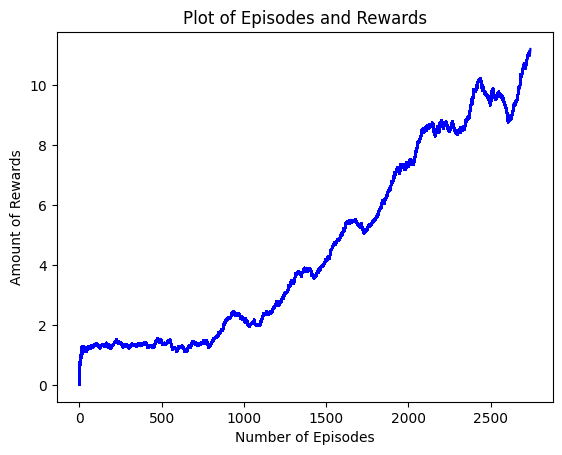

In [ ]:
rl_rewards, episodes = [], []
best_rl_reward_from_eval = 0
for e in range(num_episodes):
    done = False
    run_score = 0

    state_history = np.zeros([5, 84, 84], dtype=np.uint8) # 5 x 84 x 84
    step = 0
    state = env.reset() # reset the environment for new episode
    subsequent_state = state
    life = max_number_of_lives_in_game # resetting life count - new game

    get_initialization_state(state_history, state, history_length) # set up the states

    while not done:
        step += 1
        cnt_frame+= 1

        if step > 1 and len(np.unique(subsequent_state[:189] == state[:189])) < 2:
            action = 0  # This is going to "fire"  - this is checking to see if you need to start the game
        else:
            action = agent.select_action(np.float32(state_history[:4, :, :]) / 255.) # converting imgs to 0-1
        state = subsequent_state
        subsequent_state, rl_reward, done, info_dictionary = env.step(action + 1)

        frame_counter_subsequent_state = process_frame(subsequent_state)
        state_history[4, :, :] = frame_counter_subsequent_state
        last_state = check_if_live(life, info_dictionary['lives'])

        life = info_dictionary['lives']
        r = rl_reward

        agent.sys_memory.record(deepcopy(frame_counter_subsequent_state), action, r, last_state)

        # only train when ready
        if(cnt_frame>= training_frames):
            agent.p_net_training(cnt_frame)
            if double_d and (cnt_frame% target_update_frequency)== 0:
                agent.target_to_policy()
        run_score += rl_reward
        state_history[:4, :, :] = state_history[1:, :, :] # cut off last

        if done:
            rl_reward_from_eval.append(run_score)
            rl_rewards.append(np.mean(rl_reward_from_eval))
            episodes.append(e)
            pylab.plot(episodes, rl_rewards, 'b')
            pylab.xlabel('Number of Episodes')
            pylab.ylabel('Amount of Rewards')
            pylab.title('Plot of Episodes and Rewards')
            pylab.savefig("./deep_q.png")

            print("For episode:", e, "  the run_score was:", run_score, "  and mem length:",
                  len(agent.sys_memory), "  eps:", agent.eps, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    eval rl_reward:", np.mean(rl_reward_from_eval))

            ### You can change this to whatever you want
            if np.mean(rl_reward_from_eval) > 5 and np.mean(rl_reward_from_eval) > best_rl_reward_from_eval:
                torch.save(agent.policy_network, "./dqn.pth")
                best_rl_reward_from_eval = np.mean(rl_reward_from_eval)


## Visualizing the Game

Be careful - you don't want to run this twice in the same kernel or it will crash. Recommend you save your model before making visualization.

In [ ]:
torch.save(agent.policy_network, "./dqn_last.pth")

In [22]:
# from gym.wrappers import Monitor # `
from gym.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
import glob
import io
import base64
from pyvirtualdisplay import Display

def vis_curr(env, step=0, info_dictionary=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Curr Step: %d %s" % ("Game",step, info_dictionary))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True) # for jupyter notebook
    ipythondisplay.display(plt.gcf()) # for jupyter

# Making a video of the jupyter
def make_video_of_jupyter():
    videos_from_glob = glob.glob('video.mp4')
    if len(videos_from_glob) > 0:
        mp4 = videos_from_glob[0] # video path
        video = io.open(mp4, 'r+b').read() # load in the video
        encoded = base64.b64encode(video) # encode in base 64  # this code below creates html for the video in jupyter
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("No video")


def environment_writer(env):
    env = RecordVideo(env, './video')
    return env

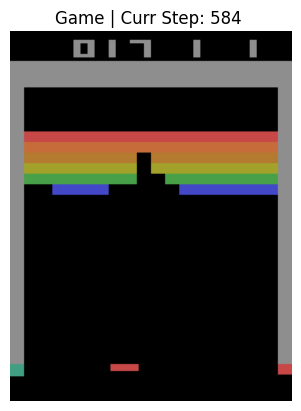

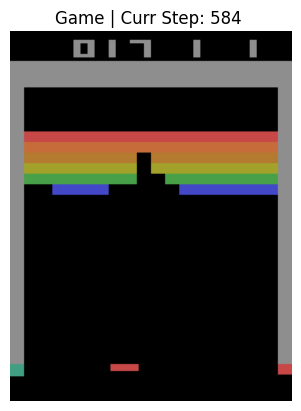

In [23]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
# might need to write code to load the agent if you are resuming here:
#load here
#############
# agent.eps = 0.0 # Why would we want this?
agent = EnvironmentAgent(action_to_take_size)
agent.load_policy_network("/content/drive/My Drive/DQN/dqn_last.pth")
agent.eps = 0.0 # Why would we want this?

env = gym.make('BreakoutDeterministic-v4',render_mode='rgb_array')
env = environment_writer(env)

done = False
run_score = 0
step = 0
state = env.reset()
subsequent_state = state
life = max_number_of_lives_in_game # this stuff is all same as above
state_history = np.zeros([5, 84, 84], dtype=np.uint8)
# get_initialization_state(state_history, state)

while not done:

    # env.render()
    vis_curr(env,step)

    step += 1
    cnt_frame+= 1

    if step > 1 and len(np.unique(subsequent_state[:189] == state[:189])) < 2:
        action = 0  # This is going to "fire"  - this is checking to see if you need to start the game
    else:
        action = agent.select_action(np.float32(state_history[:4, :, :]) / 255.) # converting imgs to 0-1
    state = subsequent_state

    # subsequent_state, rl_reward, done, info_dictionary = env.step(action_to_take + 1)
    subsequent_state, rl_reward, done, info_dictionary = env.step(action + 1)

    frame_counter_subsequent_state = process_frame(subsequent_state)
    state_history[4, :, :] = frame_counter_subsequent_state
    last_state = check_if_live(life, info_dictionary['lives'])

    life = info_dictionary['lives'] # lives in gym
    r = np.clip(rl_reward, -1, 1)  # clipping reward between -1 and 1
    r = rl_reward

    agent.sys_memory.record(deepcopy(frame_counter_subsequent_state), action, r, last_state)

    run_score += rl_reward

    state_history[:4, :, :] = state_history[1:, :, :]

env.close()
make_video_of_jupyter()
display.stop()

**Analysis of Graphs**


# *Normal DQN Training Progress:*

The graph displays a general upward trend in the rewards over episodes, indicating improvement in the agent's performance as training progresses.
The graph shows some fluctuations, but these tend to decrease as the number of episodes increases, suggesting some degree of learning stabilization.

*Double DQN Training Progress:*
The Double DQN also shows an improvement in rewards over time, which is typical as the agent explores and exploits the environment.
The rewards seem to stabilize earlier than in the normal DQN setup, and the peaks of rewards are generally higher, indicating potentially more effective learning and better policy stabilization.

**Comparative Insights:**

*Stability and Performance:* The Double DQN appears to achieve a more stable and higher reward faster than the normal DQN. This could be attributed to the reduced overestimation of Q-values inherent in the Double DQN method.
Consistency: Double DQN shows less variance in rewards towards the later episodes compared to normal DQN, suggesting that Double DQN might be more consistent in its performance across different states of the environment.

**We also see Double DQ is a better player and has a better score overall.**

## **Please check the video in my ipynb for both double DQ and normal DQ.**

In [24]:
print('Thanks for taking the effort to grade folks. As a Graduate Student myself I understand the pain juggling courses, grades and life. Cya on the other side. Cheers!')

Thanks for taking the effort to grade folks. As a Graduate Student myself I understand the pain juggling courses, grades and life. Cya on the other side. Cheers!
